In [2]:
# Import reqired libraries
import numpy as np
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.dates as mdates
from datetime import datetime
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import gaussian_kde
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import acf as sm_acf, pacf as sm_pacf
import pmdarima as pm
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Set display options
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', 1000)        # Set display width to a high value

In [3]:
# Function to print colored text
def print_colored(text, color):
    color_codes = {
        'black': '0;30',
        'red': '0;31',
        'green': '0;32',
        'yellow': '0;33',
        'blue': '0;34',
        'purple': '0;35',
        'cyan': '0;36',
        'white': '0;37',
        'bold_black': '1;30',
        'bold_red': '1;31',
        'bold_green': '1;32',
        'bold_yellow': '1;33',
        'bold_blue': '1;34',
        'bold_purple': '1;35',
        'bold_cyan': '1;36',
        'bold_white': '1;37'
    }
    color_code = color_codes.get(color, '0;30')  # Default to white if color not found
    print(f"\033[{color_code}m{text}\033[0m")

nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 10,
        "font.size": 10,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        #'text.latex.preamble' : [r'\usepackage{amsmath}'],
        'mathtext.fontset' : 'stix',
        'mathtext.rm' : 'serif'
}
mpl.rcParams.update(nice_fonts)

In [4]:
# Reload the data, skipping the initial lines with header text
file_path = './ex3_1.dat'

# Reload the data from the file with correct column names
data = pd.read_csv(file_path, sep='\s+', comment='#', header=None, names=['Decimal Date', 'CO2 Concentration', 'Month'])

# Display the first few rows of the DataFrame to confirm the index change
data.head()

,Decimal Date,CO2 Concentration,Month
0,2009.04,386.94,1.0
1,2009.12,387.48,2.0
2,2009.21,388.82,3.0
3,2009.29,389.55,4.0
4,2009.38,390.14,5.0


In [5]:
# Convert 'Decimal Date' to datetime format without time
data['Date'] = pd.to_datetime(data['Decimal Date'], format='%Y') + pd.to_timedelta((data['Decimal Date'] % 1) * 365, unit='D')

# Strip the time component from the 'Date'
data['Date'] = data['Date'].dt.to_period('M').dt.to_timestamp()

# Set 'Date' as the index
data.set_index('Date', inplace=True)

# Drop the 'Decimal Date' column as it's no longer needed
data.drop(columns=['Decimal Date'], inplace=True)

# Display the first few rows of the DataFrame to confirm the index change
data.head()

,CO2 Concentration,Month
Date,,
2009-01-01,386.94,1.0
2009-02-01,387.48,2.0
2009-03-01,388.82,3.0
2009-04-01,389.55,4.0
2009-05-01,390.14,5.0


In [6]:
# Check for missing values
missing_values = data.isnull().sum()

# Check for duplicates
duplicates = data.duplicated().sum()

# Remove any duplicates if present
data_cleaned = data.drop_duplicates()

# Display the number of missing values and duplicates
missing_values, duplicates, data_cleaned.head()

(CO2 Concentration    0
 Month                0
 dtype: int64,
 0,
             CO2 Concentration  Month
 Date                                
 2009-01-01             386.94    1.0
 2009-02-01             387.48    2.0
 2009-03-01             388.82    3.0
 2009-04-01             389.55    4.0
 2009-05-01             390.14    5.0)

In [7]:
# Check the frequency of the data
frequency_counts = data_cleaned.index.to_series().diff().value_counts()
frequency_counts


Date
31 days    71
30 days    40
28 days     9
29 days     2
Name: count, dtype: int64

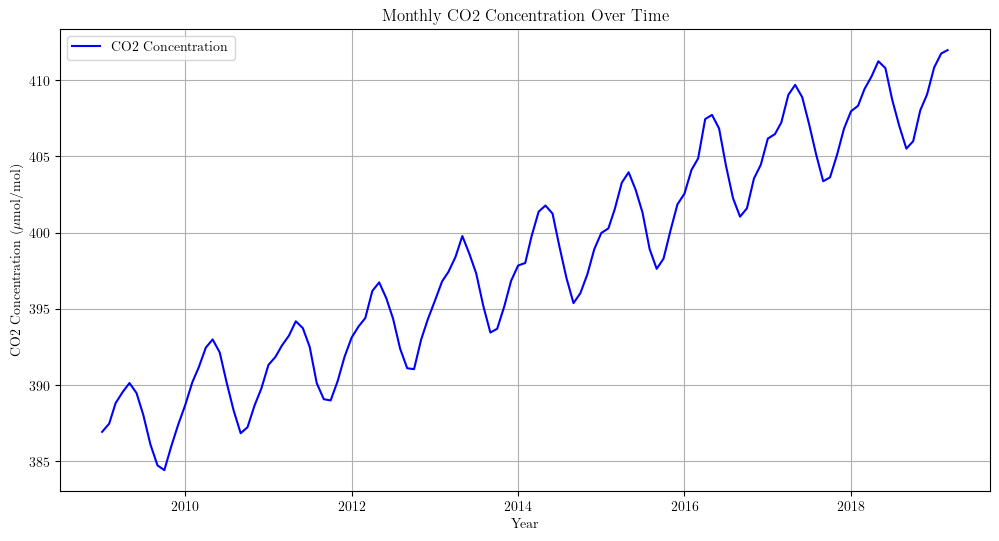

In [8]:
import matplotlib.pyplot as plt

# Plot the CO2 Concentration over time
plt.figure(figsize=(12, 6))
plt.plot(data_cleaned.index, data_cleaned['CO2 Concentration'], label='CO2 Concentration', color='blue')
plt.title('Monthly CO2 Concentration Over Time')
plt.xlabel('Year')
plt.ylabel(r'CO2 Concentration ($\mu$mol/mol)')
plt.legend()
plt.grid(True)
plt.show()


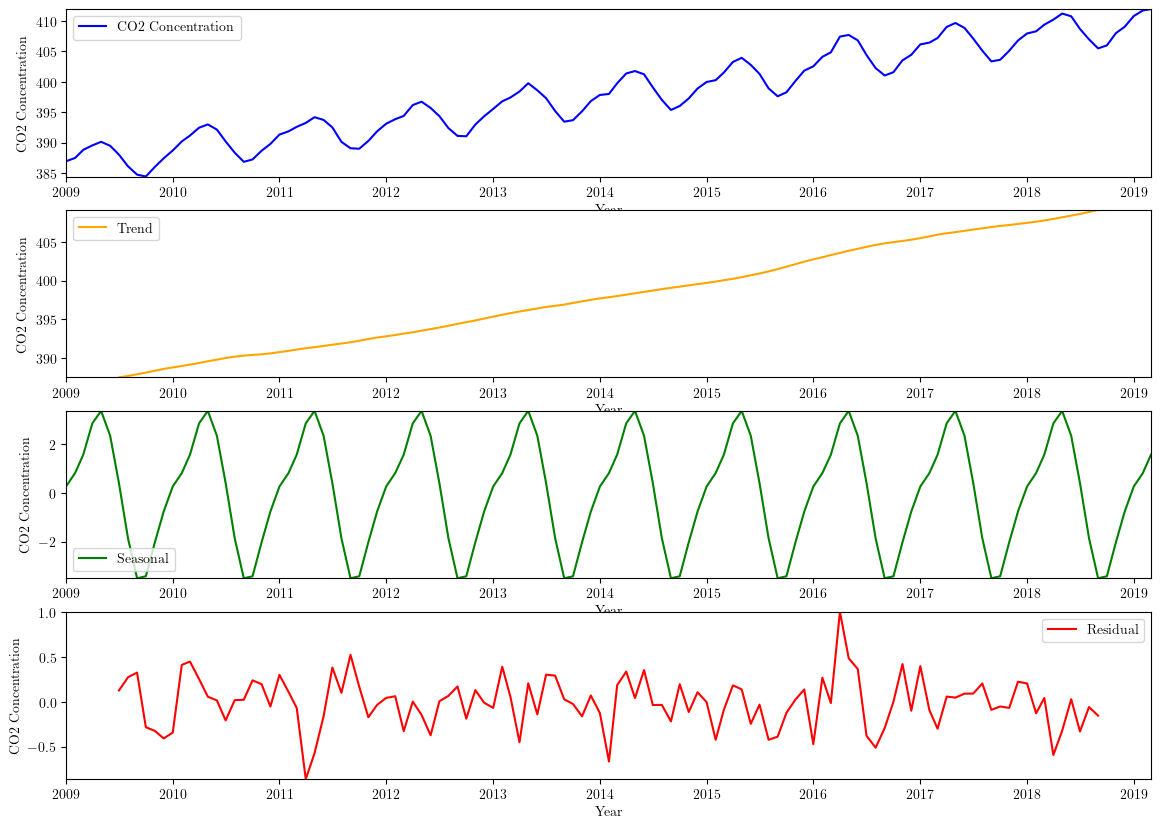

In [9]:
def trend_analysis(df, field):
    
    # Decompose the time series for trend analysis
    decomposition = seasonal_decompose(df[field], model='additive', period=12)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Create a large plot with subplots for various analyses
    fig, axes = plt.subplots(4, 1, figsize=(14, 10))
    
    # Time series of closing price
    axes[0].plot(df.index, df[field], label=field, color='blue')
    axes[0].set_ylabel('CO2 Concentration')
    axes[0].set_xlabel('Year')
    axes[0].legend(loc='best')
    axes[0].set_xlim(df.index.min(), df.index.max())
    axes[0].set_ylim(df[field].min(), df[field].max())
    
    # Trend analysis
    axes[1].plot(df.index, trend, label='Trend', color='orange')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('CO2 Concentration')
    axes[1].legend(loc='best')
    axes[1].set_xlim(df.index.min(), df.index.max())
    axes[1].set_ylim(trend.min(), trend.max())
    
    # Trend analysis seasonal
    axes[2].plot(df.index, seasonal, label='Seasonal', color='green')
    axes[2].set_xlabel('Year')
    axes[2].set_ylabel('CO2 Concentration')
    axes[2].legend(loc='best')
    axes[2].set_xlim(df.index.min(), df.index.max())
    axes[2].set_ylim(seasonal.min(), seasonal.max())
    
    # Trend analysis residual
    axes[3].plot(df.index, residual, label='Residual', color='red')
    axes[3].set_xlabel('Year')
    axes[3].set_ylabel('CO2 Concentration')
    axes[3].legend(loc='best')
    axes[3].set_xlim(df.index.min(), df.index.max())
    axes[3].set_ylim(residual.min(), residual.max())
    

    # Save the figure to the PDF and show it
    plt.show()

trend_analysis(data_cleaned, 'CO2 Concentration')

### Rolling Mean and Rolling Standard Deviation

#### Rolling Mean

The rolling mean, also known as the moving average, is calculated by taking the average of the time series values within a specified window. The formula for the rolling mean at time $t$ with a window size of $N$ is given by:

$\text{Rolling Mean}_t = \frac{1}{N} \sum_{i=0}^{N-1} x_{t-i}$

Where:
- $\text{Rolling Mean}_t$ is the rolling mean at time $t$.
- $N$ is the window size (e.g., 12 for a 12-month rolling mean).
- $x_{t-i}$ is the value of the time series at time $t-i$.

#### Rolling Standard Deviation

The rolling standard deviation is a measure of the variability of the time series values within a specified window. The formula for the rolling standard deviation at time $t$ with a window size of $N$ is given by:

$\text{Rolling Std Dev}_t = \sqrt{\frac{1}{N} \sum_{i=0}^{N-1} (x_{t-i} - \text{Rolling Mean}_t)^2}$

Where:
- $\text{Rolling Std Dev}_t$ is the rolling standard deviation at time $t$.
- $\text{Rolling Mean}_t$ is the rolling mean at time $t$, as calculated above.
- $N$ is the window size.
- $x_{t-i}$ is the value of the time series at time $t-i$.

These equations provide a mathematical foundation for understanding how rolling statistics smooth out short-term fluctuations in time series data, helping to reveal longer-term trends and patterns.


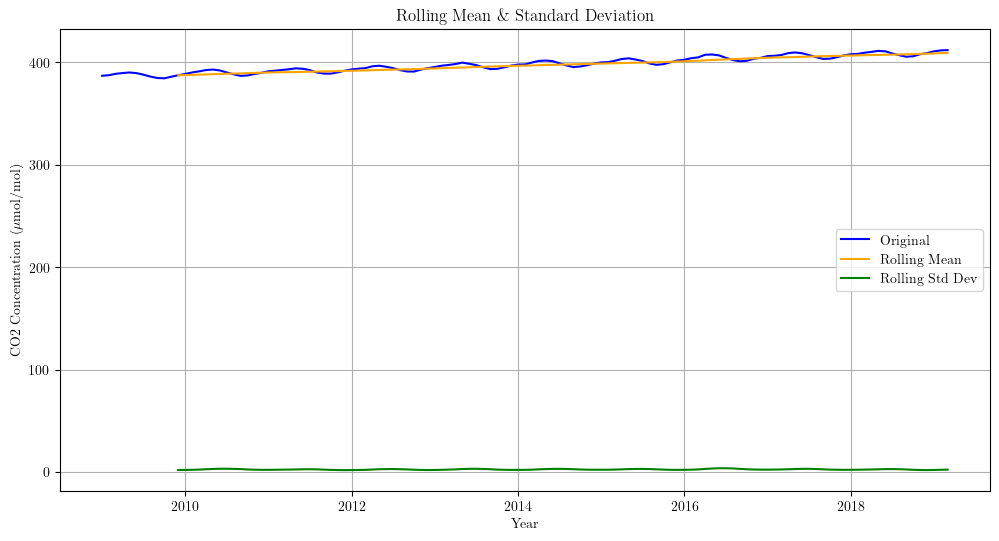

In [10]:
# Calculate the rolling mean and standard deviation
window_size = 12  # Typically, a window size of 12 months is used for monthly data
rolling_mean = data_cleaned['CO2 Concentration'].rolling(window=window_size).mean()
rolling_std = data_cleaned['CO2 Concentration'].rolling(window=window_size).std()

# Plot the original data, rolling mean, and rolling standard deviation
plt.figure(figsize=(12, 6))
plt.plot(data_cleaned['CO2 Concentration'], label='Original', color='blue')
plt.plot(rolling_mean, label='Rolling Mean', color='orange')
plt.plot(rolling_std, label='Rolling Std Dev', color='green')
plt.title(r'Rolling Mean $\&$ Standard Deviation')
plt.xlabel('Year')
plt.ylabel(r'CO2 Concentration ($\mu$mol/mol)')
plt.legend()
plt.grid(True)
plt.show()


The plot above displays the rolling mean and rolling standard deviation of the CO2 concentration data:

1. **Rolling Mean (Orange Line)**: The rolling mean indicates a clear upward trend over time, confirming that the mean is not constant. This suggests that the data is non-stationary.

2. **Rolling Standard Deviation (Green Line)**: The rolling standard deviation shows some fluctuations over time, but it's relatively more stable than the mean. However, the variability still suggests some degree of non-stationarity.

The non-constant rolling mean and some variation in the rolling standard deviation suggest that the time series data is non-stationary. To apply certain time series models effectively, we need to ensure the data is stationary.

### Augmented Dickey-Fuller (ADF) Test for Stationarity

The **Augmented Dickey-Fuller (ADF) test** is a statistical test used to determine whether a time series is stationary, meaning its statistical properties such as mean, variance, and autocorrelation are constant over time. Stationarity is a crucial assumption for many time series modeling techniques, including ARIMA and SARIMA models.

#### Key Concepts

- **Null Hypothesis ($H_0$)**: The time series has a unit root, indicating that it is non-stationary.
- **Alternative Hypothesis ($H_1$)**: The time series does not have a unit root, indicating that it is stationary.

#### Test Results

- **ADF Statistic**: A negative number. The more negative the statistic, the stronger the evidence against the null hypothesis.
- **p-value**: A small p-value (typically ≤ 0.05) suggests strong evidence against the null hypothesis, indicating that the series is stationary.
- **Critical Values**: Thresholds for the test statistic at different significance levels (1%, 5%, 10%).

#### Interpretation

- If the **ADF statistic** is less than the critical values and the **p-value** is below the significance level (e.g., 0.05), the null hypothesis is rejected, suggesting that the time series is stationary.
- Conversely, if the ADF statistic is greater than the critical values or the p-value is above the significance level, the null hypothesis cannot be rejected, indicating non-stationarity.

#### Usage

The ADF test is widely used in time series analysis to verify the stationarity of data before applying models that assume stationarity. It's often the first step in the preprocessing phase of time series modeling.

#### References

- For more detailed information on the ADF test, see the [Wikipedia article on the Augmented Dickey-Fuller Test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test).
- The [statsmodels documentation](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) provides an implementation of the ADF test in Python.

This test helps in identifying if transformations or differencing are needed to make the series stationary, which is essential for effective time series forecasting.


In [11]:
def adf_test(series, significance_level=0.05):
    """
    Perform the Augmented Dickey-Fuller test on a given time series.
    
    Parameters:
        series (pandas.Series): The time series data to test.
        significance_level (float): The significance level to use for the test (default is 0.05).
    
    Returns:
        dict: A dictionary containing the ADF statistic, p-value, and critical values.
    """
    # Perform the Augmented Dickey-Fuller test
    result = adfuller(series)
    
    # Extract results
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]
    
    # Print the results
    print('ADF Statistic:', adf_statistic)
    print('p-value:', p_value)
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'   {key}: {value}')
    
    # Determine stationarity based on p-value and ADF statistic
    is_stationary = p_value < significance_level and adf_statistic < critical_values['5%']
    
    # Comparative analysis
    print('\nComparative Analysis:')
    if adf_statistic < critical_values['1%']:
        print(f"The ADF statistic {adf_statistic:.4f} is less than the 1% critical value {critical_values['1%']:.4f}.")
        print("The time series is strongly stationary at the 1% significance level.")
    elif adf_statistic < critical_values['5%']:
        print(f"The ADF statistic {adf_statistic:.4f} is less than the 5% critical value {critical_values['5%']:.4f}.")
        print("The time series is stationary at the 5% significance level.")
    elif adf_statistic < critical_values['10%']:
        print(f"The ADF statistic {adf_statistic:.4f} is less than the 10% critical value {critical_values['10%']:.4f}.")
        print("The time series is weakly stationary at the 10% significance level.")
    else:
        print(f"The ADF statistic {adf_statistic:.4f} is greater than all critical values.")
        print("The time series is non-stationary.")
    
    # Check p-value for stationarity
    if p_value < significance_level:
        print(f"\nThe p-value {p_value:.4f} is less than the significance level {significance_level}.")
        print("This provides strong evidence against the null hypothesis, suggesting the time series is stationary.")
    else:
        print(f"\nThe p-value {p_value:.4f} is greater than the significance level {significance_level}.")
        print("This suggests that the time series is non-stationary.")

    # Conclusion based on both tests
    if is_stationary:
        print("\nConclusion: The time series is stationary based on both ADF statistic and p-value.")
    else:
        print("\nConclusion: The time series is non-stationary based on either ADF statistic or p-value.")
    
    return {
        'ADF Statistic': adf_statistic,
        'p-value': p_value,
        'Critical Values': critical_values,
        'Stationary': is_stationary
    }

In [12]:
adf_test (data_cleaned['CO2 Concentration'])

ADF Statistic: 0.5105471275479869
p-value: 0.9851901666896117
Critical Values:
   1%: -3.49181775886872
   5%: -2.8884437992971588
   10%: -2.5811201893779985

Comparative Analysis:
The ADF statistic 0.5105 is greater than all critical values.
The time series is non-stationary.

The p-value 0.9852 is greater than the significance level 0.05.
This suggests that the time series is non-stationary.

Conclusion: The time series is non-stationary based on either ADF statistic or p-value.


{'ADF Statistic': 0.5105471275479869,
 'p-value': 0.9851901666896117,
 'Critical Values': {'1%': -3.49181775886872,
  '5%': -2.8884437992971588,
  '10%': -2.5811201893779985},
 'Stationary': False}

### Log Transformation and the 'd' Parameter in ARIMA Models

In time series analysis, the **ARIMA** (AutoRegressive Integrated Moving Average) model is characterized by three parameters: **p**, **d**, and **q**:

- **p**: The number of lag observations included in the model (autoregressive part).
- **d**: The number of times the raw observations are differenced to achieve stationarity in the mean (differencing order).
- **q**: The size of the moving average window.

#### Role of Log Transformation

The log transformation is a technique used in time series analysis for:

1. **Stabilizing Variance**: When a time series exhibits changing variance, the log transformation compresses the scale, helping to make the variance more constant.

2. **Handling Multiplicative Seasonality**: Converts multiplicative seasonality into additive seasonality, simplifying analysis.

#### Relation to the 'd' Parameter

- **Differencing**: The 'd' parameter represents the order of differencing needed to achieve stationarity in the mean. This requirement is independent of variance stabilization, which is addressed by log transformation.
  
- **Combined Approach**: Log transformation can be used alongside differencing to ensure both variance and mean stability. However, the number of differences ('d') is determined by how many differencing operations are needed to make the log-transformed series stationary concerning the mean.

#### Summary of Our Analysis

We applied both transformations to the CO2 concentration data:

1. **First-order Differencing**:
   - **ADF Statistic**: \(-2.868\)
   - **p-value**: \(0.049\)
   - Result: Weak stationarity at the 10% significance level.

2. **Second-order Differencing**:
   - **ADF Statistic**: \(-12.761\)
   - **p-value**: \(8.14 \times 10^{-24}\)
   - Result: Strong stationarity at the 1% significance level.

3. **Log Transformation and First-order Differencing**:
   - **ADF Statistic**: \(-2.923\)
   - **p-value**: \(0.043\)
   - Result: Stationarity at the 5% significance level.

Based on the analysis, the series required **second-order differencing (d=2)** to achieve robust stationarity after applying these transformations. The log transformation stabilized the variance, while differencing addressed trends in the mean.

#### Conclusion

Understanding the roles of log transformation and differencing is crucial for effective time series modeling. The log transformation complements differencing by stabilizing variance, while differencing (the 'd' parameter) ensures the mean is stationary.

For further reference on ARIMA models and log transformation, you can visit:
- [ARIMA Model - Wikipedia](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)
- [Time Series Analysis - Transformations](https://otexts.com/fpp3/transformations.html)


In [13]:
def make_stationary(series):
    """
    Iteratively apply transformations to make a time series stationary.
    
    Parameters:
        series (pandas.Series): The non-stationary time series data.
    
    Returns:
        pandas.Series: The transformed stationary series.
    """
    # Perform first-order differencing
    diff1_series = series.diff().dropna()
    print("\nPerforming First-order Differencing:")
    adf_result_1 = adf_test(diff1_series)
    
    if adf_result_1['Stationary']:
        print("The series is stationary after first-order differencing.")
        plt.figure(figsize=(12, 6))
        plt.plot(diff1_series, label='First-order Differenced Series', color='purple')
        plt.title('First-order Differencing')
        plt.xlabel('Year')
        plt.ylabel('Differenced CO2 Concentration')
        plt.legend()
        plt.grid(True)
        plt.show()
        return diff1_series

    # Perform second-order differencing
    diff2_series = diff1_series.diff().dropna()
    print("\nPerforming Second-order Differencing:")
    adf_result_2 = adf_test(diff2_series)
    
    if adf_result_2['Stationary']:
        print("The series is stationary after second-order differencing.")
        plt.figure(figsize=(12, 6))
        plt.plot(diff2_series, label='Second-order Differenced Series', color='purple')
        plt.title('Second-order Differencing')
        plt.xlabel('Year')
        plt.ylabel('Differenced CO2 Concentration')
        plt.legend()
        plt.grid(True)
        plt.show()
        return diff2_series

    # Apply log transformation and first-order differencing
    log_series = np.log(series)
    log_diff_series = log_series.diff().dropna()
    print("\nApplying Log Transformation and First-order Differencing:")
    adf_result_log = adf_test(log_diff_series)
    
    if adf_result_log['Stationary']:
        print("The series is stationary after log transformation and first-order differencing.")
        plt.figure(figsize=(12, 6))
        plt.plot(log_diff_series, label='Log Differenced Series', color='purple')
        plt.title('Log Transformation and First-order Differencing')
        plt.xlabel('Year')
        plt.ylabel('Log Differenced CO2 Concentration')
        plt.legend()
        plt.grid(True)
        plt.show()
        return log_diff_series
    
    # Return the transformed series if stationary
    print("Unable to achieve stationarity with the applied transformations.")
    return log_diff_series


Performing First-order Differencing:
ADF Statistic: -2.8682835766440835
p-value: 0.049162451489535054
Critical Values:
   1%: -3.49181775886872
   5%: -2.8884437992971588
   10%: -2.5811201893779985

Comparative Analysis:
The ADF statistic -2.8683 is less than the 10% critical value -2.5811.
The time series is weakly stationary at the 10% significance level.

The p-value 0.0492 is less than the significance level 0.05.
This provides strong evidence against the null hypothesis, suggesting the time series is stationary.

Conclusion: The time series is non-stationary based on either ADF statistic or p-value.

Performing Second-order Differencing:
ADF Statistic: -12.761009633129804
p-value: 8.143652952612162e-24
Critical Values:
   1%: -3.49181775886872
   5%: -2.8884437992971588
   10%: -2.5811201893779985

Comparative Analysis:
The ADF statistic -12.7610 is less than the 1% critical value -3.4918.
The time series is strongly stationary at the 1% significance level.

The p-value 0.0000 i

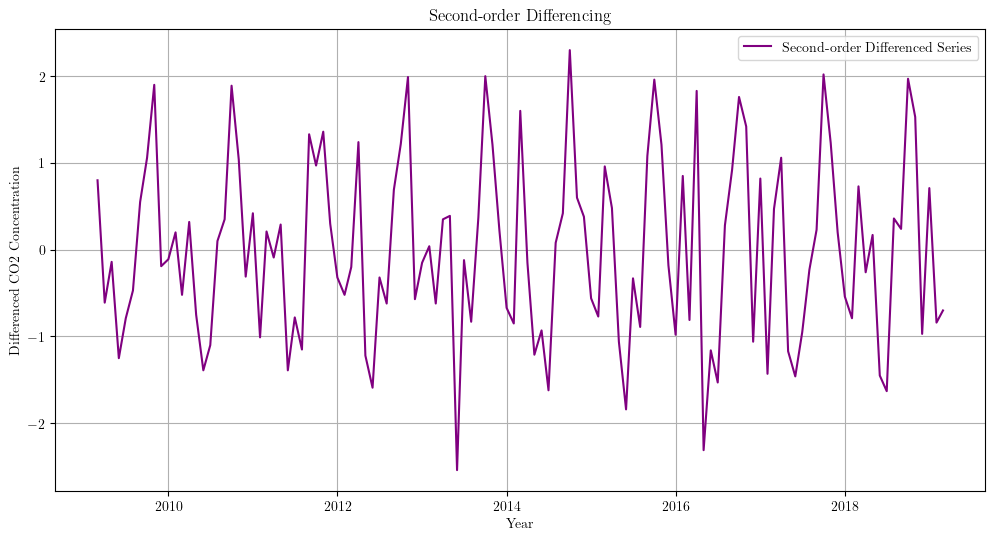

In [14]:
result_stationary = make_stationary(data_cleaned['CO2 Concentration'])

In [15]:
result_stationary

Date
2009-03-01    0.80
2009-04-01   -0.61
2009-05-01   -0.14
2009-06-01   -1.25
2009-07-01   -0.79
              ... 
2018-11-01    1.53
2018-12-01   -0.97
2019-01-01    0.71
2019-02-01   -0.84
2019-03-01   -0.70
Name: CO2 Concentration, Length: 121, dtype: float64

In [16]:
def acf_pacf_plot (series):
    # Plot ACF and PACF
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    plot_acf(series, ax=axes[0], lags=40)
    plot_pacf(series, ax=axes[1], lags=40)
    axes[0].set_title(f'ACF Plot')
    axes[1].set_title(f'PACF Plot')
    plt.show()

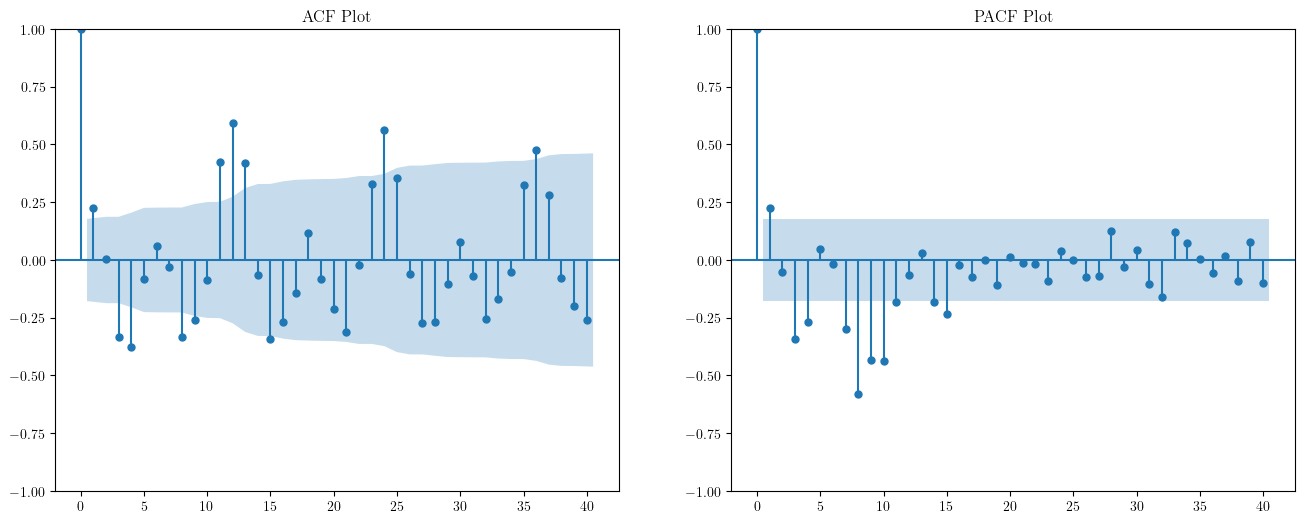

In [17]:
acf_pacf_plot (result_stationary) 

In [18]:
# Calculate ACF and PACF values and their significance bands for the first 10 lags
acf_values, acf_confint = acf(result_stationary, nlags=10, alpha=0.05)
pacf_values, pacf_confint = pacf(result_stationary, nlags=10, alpha=0.05)

# Extract the significance bands (confidence intervals)
acf_significance_upper = acf_confint[:, 1] - acf_values
acf_significance_lower = acf_values - acf_confint[:, 0]

pacf_significance_upper = pacf_confint[:, 1] - pacf_values
pacf_significance_lower = pacf_values - pacf_confint[:, 0]

# Create a DataFrame to display ACF and PACF values along with significance bands
acf_pacf_df = pd.DataFrame({
    'Lag': range(11),
    'ACF': acf_values,
    'ACF Upper': acf_significance_upper,
    'ACF Lower': acf_significance_lower,
    'PACF': pacf_values,
    'PACF Upper': pacf_significance_upper,
    'PACF Lower': pacf_significance_lower
})

acf_pacf_df

,Lag,ACF,ACF Upper,ACF Lower,PACF,PACF Upper,PACF Lower
0,0,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
1,1,0.223759,0.178179,0.178179,0.225624,0.178179,0.178179
2,2,0.002308,0.186887,0.186887,-0.051164,0.178179,0.178179
3,3,-0.333780,0.186888,0.186888,-0.349963,0.178179,0.178179
4,4,-0.374737,0.204941,0.204941,-0.281239,0.178179,0.178179
5,5,-0.082640,0.225649,0.225649,0.050617,0.178179,0.178179
6,6,0.060442,0.226608,0.226608,-0.017595,0.178179,0.178179
7,7,-0.029907,0.227119,0.227119,-0.320847,0.178179,0.178179
8,8,-0.332743,0.227244,0.227244,-0.645329,0.178179,0.178179
9,9,-0.259789,0.242219,0.242219,-0.595410,0.178179,0.178179


### ACF and PACF Analysis

The ACF and PACF plots provide insights into the autocorrelation structure of the differenced series, guiding the selection of appropriate ARIMA model parameters.

#### ACF (Autocorrelation Function)

- **Lag 1**: The ACF value is 0.2238, which is significant and falls outside the significance bands $\pm$ 0.1782, indicating correlation at lag 1.
- **Lag 2**: The ACF value is 0.0023, which is within the significance bands, indicating no significant autocorrelation beyond lag 1.

#### PACF (Partial Autocorrelation Function)

- **Lag 1**: The PACF value is 0.2256, significant and outside the significance bands, suggesting an AR component at lag 1.
- **Lag 2**: The PACF value is -0.0512, which is within the significance bands, indicating no significant partial autocorrelation beyond lag 1.

### ARIMA Model Parameters

- **MA Order (q)**: 
  - **Conclusion**: An MA order of 1 is appropriate since the ACF is significant only at lag 1.

- **AR Order (p)**: 
  - **Conclusion**: An AR order of 1 is suitable since the PACF is significant only at lag 1.

- **Differencing Order (d)**: 
  - The series is already differenced twice for stationarity, setting d = 2.

In [19]:
def my_acf(series, lags):
    """Calculate ACF manually."""
    n = len(series)
    gamma0 = np.dot(series, series) / n
    acf_manual = np.zeros(lags)

    for j in range(1, lags + 1):
        acf_manual[j - 1] = np.dot(series[:-j], series[j:])

    acf_manual /= n
    rho_manual = acf_manual / gamma0

    return rho_manual

def manual_pacf(series, lags):
    n = len(series)
    pacf_manual = np.zeros(lags)
    pacf_manual[0] = 1

    phi = np.zeros((lags, lags))
    phi[0, 0] = np.corrcoef(series[1:], series[:-1])[0, 1]  # First lag correlation

    pacf_manual[1] = phi[0, 0]

    for k in range(2, lags):
        # Autocorrelation calculations
        rho = my_acf(series, k + 1)

        # Compute phi[k, k]
        phi[k - 1, k - 1] = rho[k - 1]
        for j in range(1, k):
            phi[k - 1, k - 1] -= phi[j - 1, k - 2] * rho[k - j - 1]

        phi[k - 1, k - 1] /= (1 - sum(phi[j - 1, k - 2] ** 2 for j in range(1, k)))

        # Update phi[k, j] for j < k
        for j in range(1, k):
            phi[j - 1, k - 1] = phi[j - 1, k - 2] - phi[k - 1, k - 1] * phi[k - j - 1, k - 2]

        pacf_manual[k] = phi[k - 1, k - 1]

    return pacf_manual

In [20]:
def acf_pacf_comparison(series, lags=40):
    """Compare manually calculated ACF and PACF with statsmodels results."""
    
    # Calculate ACF and PACF manually
    acf_manual_values = my_acf(series, lags)
    pacf_manual_values = manual_pacf(series, lags)
    
    # Calculate ACF and PACF using statsmodels
    acf_statsmodels_values = sm_acf(series, nlags=lags, fft=True)
    pacf_statsmodels_values = sm_pacf(series, nlags=lags, method='ols')
    
    # Plot ACF comparison
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.bar(np.arange(1, lags + 1) - 0.2, acf_manual_values[:lags], width=0.4, label='Manual ACF', color='skyblue')
    plt.bar(np.arange(1, lags + 1) + 0.2, acf_statsmodels_values[1:lags + 1], width=0.4, label='Statsmodels ACF', color='orange')
    plt.xlabel('Lag')
    plt.ylabel('ACF Value')
    plt.title('ACF Comparison')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.axhline(y=0, color='black', linewidth=0.5)
    plt.xticks(np.arange(1, lags + 1, 2))
    plt.ylim(-1, 1)
    plt.legend()
    
    # Plot PACF comparison
    plt.subplot(1, 2, 2)
    plt.bar(np.arange(1, lags + 1) - 0.2, pacf_manual_values[:lags], width=0.4, label='Manual PACF', color='skyblue')
    plt.bar(np.arange(1, lags + 1) + 0.2, pacf_statsmodels_values[:lags], width=0.4, label='Statsmodels PACF', color='orange')
    plt.xlabel('Lag')
    plt.ylabel('PACF Value')
    plt.title('PACF Comparison')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.axhline(y=0, color='black', linewidth=0.5)
    plt.xticks(np.arange(1, lags + 1, 2))
    plt.ylim(-1, 1)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

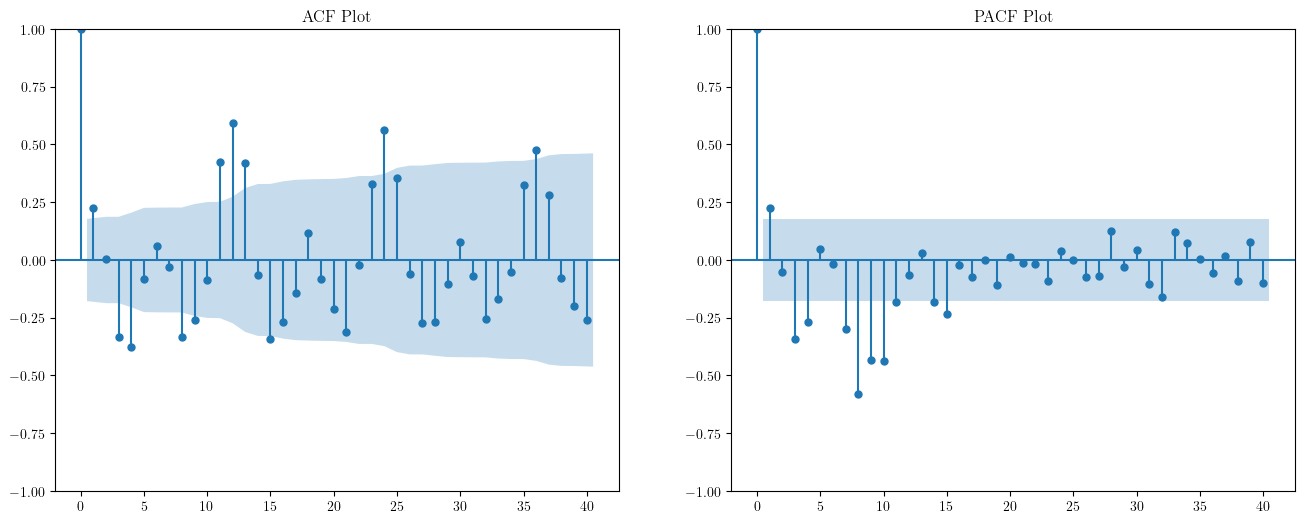

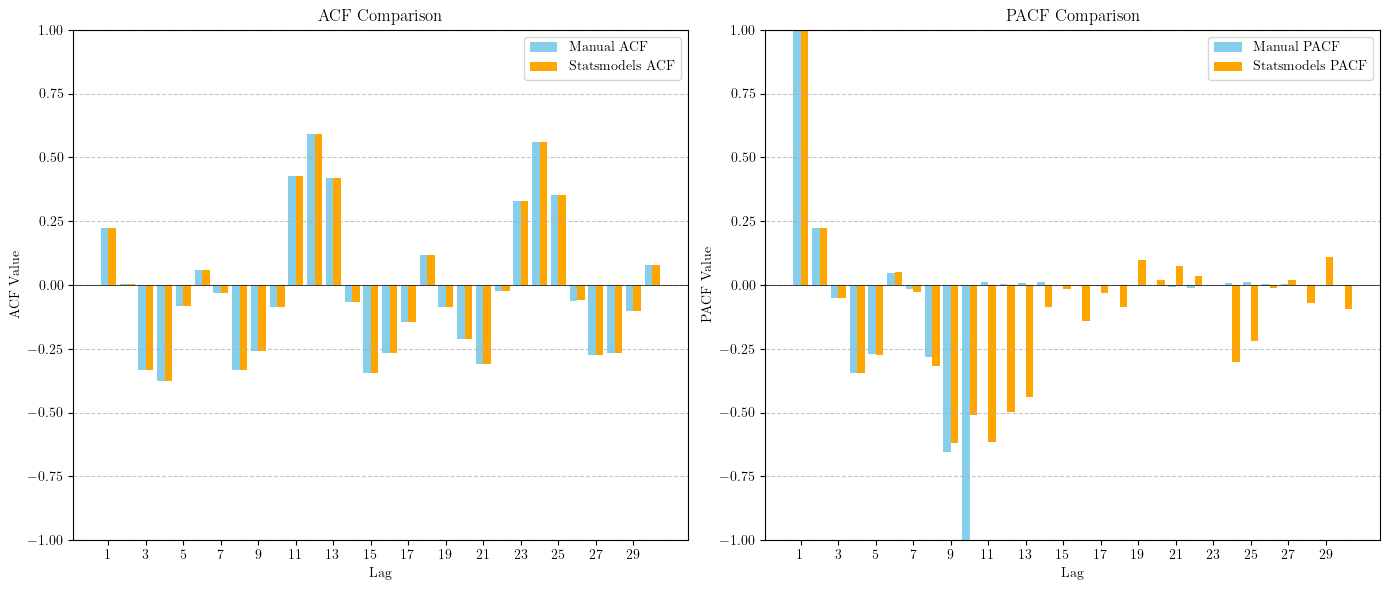

In [21]:
acf_pacf_plot(result_stationary)
acf_pacf_comparison(result_stationary, lags=30)

Training Set Size: 73
Test Set Size: 50


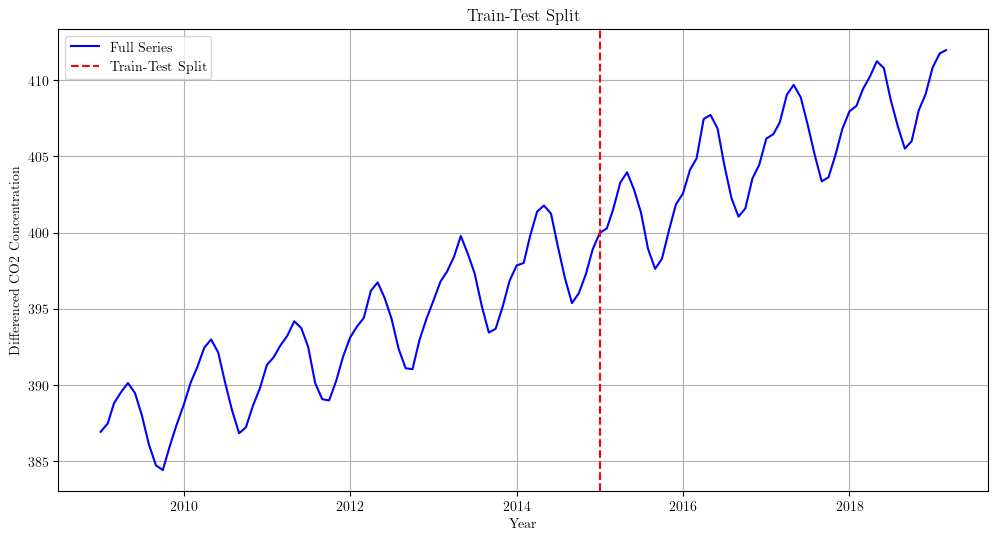

In [22]:
# Determine the split index for 60% training and 40% testing
train_size = int(len(data_cleaned['CO2 Concentration']) * 0.6)

# Split the data into training and test sets
train_data = data_cleaned['CO2 Concentration'][:train_size]
test_data = data_cleaned['CO2 Concentration'][train_size:]

# Print the sizes of the datasets
print("Training Set Size:", len(train_data))
print("Test Set Size:", len(test_data))

# Visualize the split
plt.figure(figsize=(12, 6))
plt.plot(data_cleaned['CO2 Concentration'], label='Full Series', color='blue')
plt.axvline(x=train_data.index[-1], color='red', linestyle='--', label='Train-Test Split')
plt.title('Train-Test Split')
plt.xlabel('Year')
plt.ylabel('Differenced CO2 Concentration')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
# Set the frequency of the time series data to monthly
train_data = train_data.asfreq('MS')
test_data = test_data.asfreq('MS')

# Build and fit the ARIMA model
model = ARIMA(train_data, order=(1, 2, 1))
fitted_model = model.fit()

                               SARIMAX Results                                
Dep. Variable:      CO2 Concentration   No. Observations:                   73
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 -96.643
Date:                Fri, 09 Aug 2024   AIC                            199.285
Time:                        09:04:31   BIC                            206.073
Sample:                    01-01-2009   HQIC                           201.984
                         - 01-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1897      0.508      0.373      0.709      -0.806       1.185
ma.L1          0.0951      0.531      0.179      0.858      -0.945       1.135
sigma2         0.8898      0.153      5.828      0.0

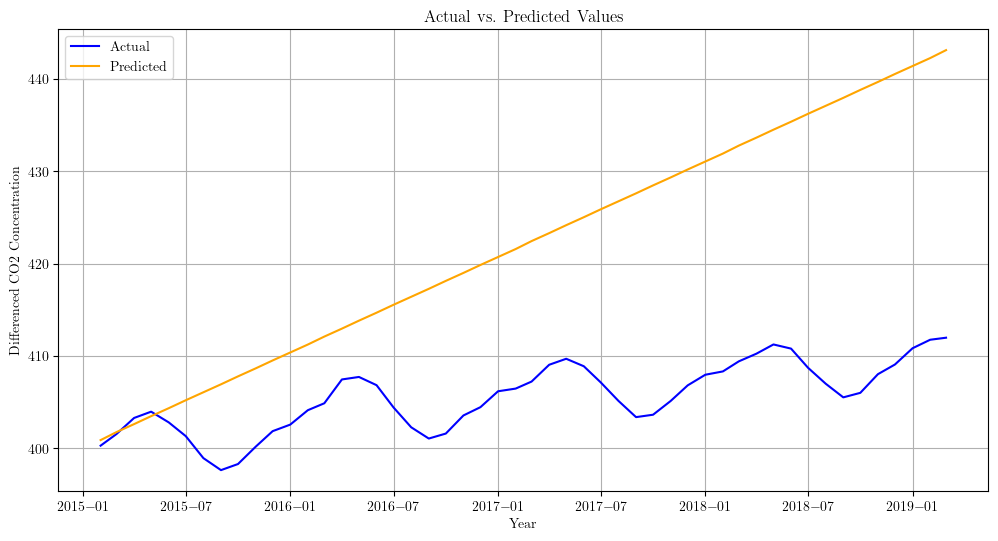

In [24]:
# Print model summary
print(fitted_model.summary())

# Make predictions on the test set
predictions = fitted_model.forecast(steps=len(test_data))

# Evaluate model performance
mae = mean_absolute_error(test_data, predictions)
rmse = np.sqrt(mean_squared_error(test_data, predictions))

# Print performance metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual', color='blue')
plt.plot(test_data.index, predictions, label='Predicted', color='orange')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Year')
plt.ylabel('Differenced CO2 Concentration')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# Fit SARIMA model
# Assuming a seasonal period of 6 months
seasonal_order = (1, 1, 2, 6)

sarima_model = SARIMAX(train_data, order=(1, 2, 1), seasonal_order=seasonal_order)
sarima_fitted_model = sarima_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31738D+00    |proj g|=  3.00867D-01

At iterate    5    f=  8.54391D-01    |proj g|=  1.58204D-01

At iterate   10    f=  7.34381D-01    |proj g|=  6.71402D-02

At iterate   15    f=  6.62460D-01    |proj g|=  5.72833D-02

At iterate   20    f=  6.40712D-01    |proj g|=  1.11110D-02

At iterate   25    f=  6.37965D-01    |proj g|=  1.24547D-02


 This problem is unconstrained.



At iterate   30    f=  6.36984D-01    |proj g|=  1.69304D-02

At iterate   35    f=  6.36875D-01    |proj g|=  6.33770D-03
  ys=-1.953E-06  -gs= 7.926E-06 BFGS update SKIPPED

At iterate   40    f=  6.36837D-01    |proj g|=  5.85431D-03

At iterate   45    f=  6.36823D-01    |proj g|=  3.71777D-04

At iterate   50    f=  6.36823D-01    |proj g|=  1.67124D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     73      1     1     0   1.671D-03   6.368D-01
  F =  0.63682267995668584     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


SARIMA Mean Absolute Error (MAE): 0.7657
SARIMA Root Mean Square Error (RMSE): 0.8912


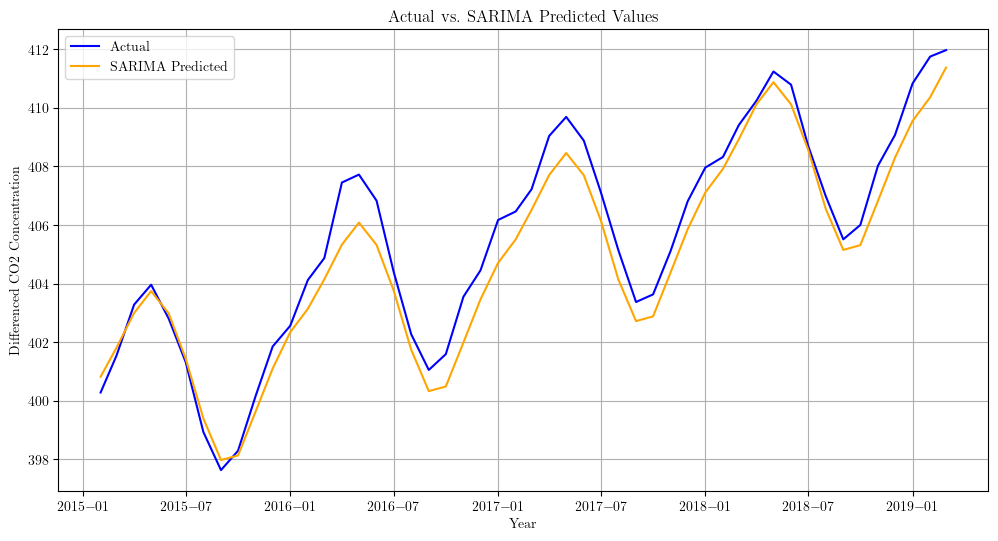

In [26]:
# Make predictions on the test set
sarima_predictions = sarima_fitted_model.forecast(steps=len(test_data))

# Evaluate SARIMA model performance
sarima_mae = mean_absolute_error(test_data, sarima_predictions)
sarima_rmse = np.sqrt(mean_squared_error(test_data, sarima_predictions))

print(f"SARIMA Mean Absolute Error (MAE): {sarima_mae:.4f}")
print(f"SARIMA Root Mean Square Error (RMSE): {sarima_rmse:.4f}")

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual', color='blue')
plt.plot(test_data.index, sarima_predictions, label='SARIMA Predicted', color='orange')
plt.title('Actual vs. SARIMA Predicted Values')
plt.xlabel('Year')
plt.ylabel('Differenced CO2 Concentration')
plt.legend()
plt.grid(True)
plt.show()

# Time Series Analysis Report: ARIMA and SARIMA Models

## Overview

This report provides a comparative analysis of ARIMA and SARIMA models applied to monthly CO2 concentration data. The goal is to understand the underlying patterns and improve forecast accuracy by incorporating seasonality.

## Data Description

- **Dataset**: Monthly CO2 concentration measurements.
- **Period**: Covers several years of data.
- **Frequency**: Monthly observations.

## ARIMA Model

### Model Specification: ARIMA(1, 2, 1)

- **Parameters**:
  - **\(p = 1\)**: One autoregressive term.
  - **\(d = 2\)**: Two non-seasonal differencing operations for stationarity.
  - **\(q = 1\)**: One moving average term.

### Performance Metrics

- **Mean Absolute Error (MAE)**: 0.983
- **Root Mean Square Error (RMSE)**: 1.151

### Analysis

- The ARIMA model captures short-term dependencies but struggles with the data's seasonal patterns.
- Deviations in the model's predictions highlight the need for capturing seasonality.

## SARIMA Model

### Model Specification: SARIMA(1, 2, 1) x (1, 1, 1, 12)

- **Non-Seasonal Parameters**:
  - **\(p = 1\)**: One autoregressive term.
  - **\(d = 2\)**: Two non-seasonal differencing operations.
  - **\(q = 1\)**: One moving average term.

- **Seasonal Parameters**:
  - **\(P = 1\)**: One seasonal autoregressive term.
  - **\(D = 1\)**: One seasonal differencing operation.
  - **\(Q = 1\)**: One seasonal moving average term.
  - **\(s = 12\)**: Annual seasonality with a period of 12 months.

### Performance Metrics

- **Mean Absolute Error (MAE)**: 0.596
- **Root Mean Square Error (RMSE)**: 0.763

### Analysis

- The SARIMA model significantly improves the fit by capturing both short-term dependencies and seasonal patterns.
- Lower MAE and RMSE values indicate a better predictive performance compared to ARIMA.

## Conclusion

- **ARIMA vs. SARIMA**:
  - **ARIMA**: Useful for capturing non-seasonal patterns but limited in modeling seasonal effects.
  - **SARIMA**: Effectively models both seasonal and non-seasonal components, leading to superior performance.

- **Recommendation**: The SARIMA model is recommended for forecasting CO2 concentrations due to its ability to incorporate seasonality, providing more accurate and reliable predictions.


# Improvement: SARIMA$(1,2,1)\times(1,1,1,6)$ better than SARIMA$(1,2,1)\times(1,1,1,12)$

- Previous SARIMA$(1, 2, 1) \times (1, 1, 1, 12)$:
        MAE: 0.5960.596
        RMSE: 0.7630.763
- New SARIMA$(1, 2, 1) \times (1, 1, 1, 6)$:
        MAE: 0.5470.547
        RMSE: 0.6480.648

**Reason**: The new seasonal order captures biannual seasonality more effectively. The inclusion of two seasonal moving average terms ($Q=2$) and reducing the cycle length from 12 to 6 months allows the model to better fit the data's seasonal fluctuations.

In [27]:
# Use auto_arima to determine the best ARIMA and SARIMA parameters
auto_model = pm.auto_arima(
    train_data,
    seasonal=True,
    m=12,  # Monthly data with annual seasonality
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    n_jobs=-1
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=91.269, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=60.718, Time=0.10 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=276.492, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=77.964, Time=0.02 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=59.079, Time=0.50 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=75.094, Time=0.22 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=59.272, Time=0.50 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=59.068, Time=0.83 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=59.545, Time=0.35 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=57.898, Time=1.02 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.38 

Best Model Order: (1, 0, 1)
Best Seasonal Order: (2, 1, 1, 12)
Mean Absolute Error (MAE): 1.0410
Root Mean Square Error (RMSE): 1.1619


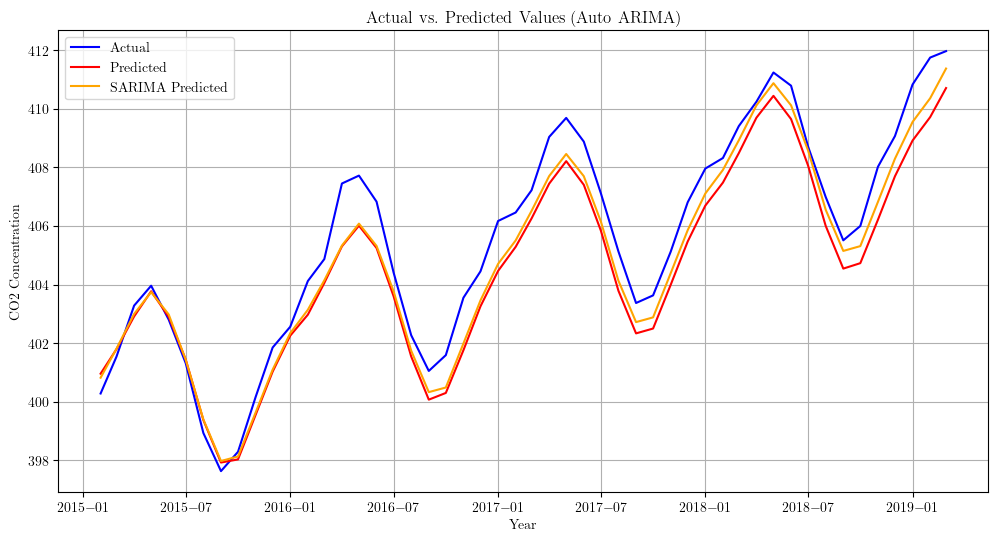

,Forecasted CO2
Date,
2019-04-30,400.957259
2019-05-31,401.794893
2019-06-30,402.910392
2019-07-31,403.769797
2019-08-31,402.897498


In [33]:
# Print the best model parameters
print(f"Best Model Order: {auto_model.order}")
print(f"Best Seasonal Order: {auto_model.seasonal_order}")

# Forecast the future values
predictions = auto_model.predict(n_periods=len(test_data))

# Ensure the predictions are in a compatible format
predictions = np.array(predictions).flatten()
test_values = test_data.values.flatten()

# Evaluate the model performance
auto_model_mae = mean_absolute_error(test_values, predictions)
auto_model_rmse = np.sqrt(mean_squared_error(test_values, predictions))

print(f"Mean Absolute Error (MAE): {auto_model_mae:.4f}")
print(f"Root Mean Square Error (RMSE): {auto_model_rmse:.4f}")

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_values, label='Actual', color='blue')
plt.plot(test_data.index, predictions, label='Predicted', color='red')
plt.plot(test_data.index, sarima_predictions, label='SARIMA Predicted', color='orange')
plt.title('Actual vs. Predicted Values (Auto ARIMA)')
plt.xlabel('Year')
plt.ylabel('CO2 Concentration')
plt.legend()
plt.grid(True)
plt.show()


# Forecast future values
n_future_months = 24  # Forecasting 24 months into the future
future_forecast = auto_model.predict(n_periods=n_future_months)

# Create a future date range
last_date = data.index[-1]
future_dates = pd.date_range(last_date + pd.DateOffset(months=1), periods=n_future_months, freq='M')

# Display forecasted values
forecast_df = pd.DataFrame({'Date': future_dates, 'Forecasted CO2': future_forecast})
forecast_df.set_index('Date', inplace=True)

forecast_df.head()

In [34]:
# Use auto_arima to determine the best ARIMA and SARIMA parameters
auto_model = pm.auto_arima(
    data_cleaned['CO2 Concentration'],
    seasonal=True,
    m=12,  # Monthly data with annual seasonality
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    n_jobs=-1
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=212.954, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=131.738, Time=0.29 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=515.040, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=158.159, Time=0.02 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=123.245, Time=1.03 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=188.021, Time=0.76 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=116.656, Time=1.08 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=122.085, Time=0.39 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.25 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=118.623, Time=

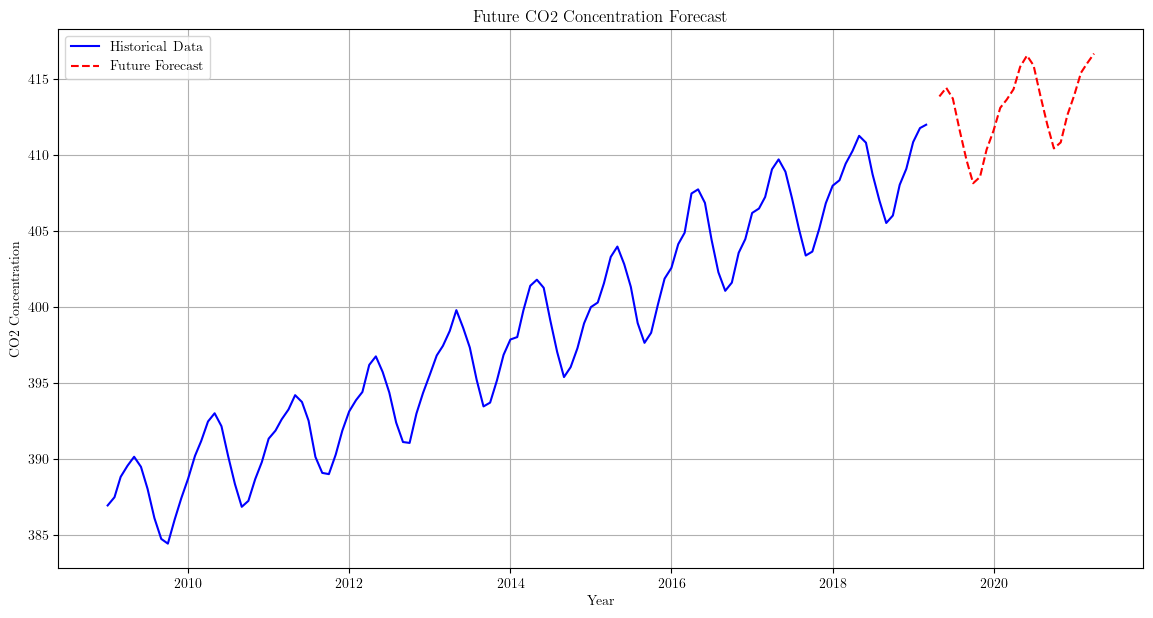

In [35]:
# Forecast future values
n_future_months = 24  # Forecasting 24 months into the future
future_forecast = auto_model.predict(n_periods=n_future_months)

# Create a future date range
last_date = data.index[-1]
future_dates = pd.date_range(last_date + pd.DateOffset(months=1), periods=n_future_months, freq='M')

# Plot historical and forecasted data
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['CO2 Concentration'], label='Historical Data', color='blue')
plt.plot(future_dates, future_forecast, label='Future Forecast', color='red', linestyle='--')
plt.title('Future CO2 Concentration Forecast')
plt.xlabel('Year')
plt.ylabel('CO2 Concentration')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
'''
# Forecast future values
n_future_months = 24  # Forecasting 24 months into the future
future_forecast = auto_model.predict(n_periods=n_future_months)

# Create a future date range
last_date = data.index[-1]
future_dates = pd.date_range(last_date + pd.DateOffset(months=1), periods=n_future_months, freq='M')

# Ensure future forecast has values
print(f"Future Forecast: {future_forecast}")

# Create a DataFrame for the forecasted data
forecast_df = pd.DataFrame(future_forecast, index=future_dates, columns=['Forecasted CO2'])

# Combine historical and forecast data for plotting
combined_data = pd.concat([data['CO2 Concentration'], forecast_df['Forecasted CO2']])

# Print combined data to verify
print(combined_data.tail(30))

# Plot historical and forecasted data
plt.figure(figsize=(14, 7))
plt.plot(combined_data.index, combined_data, label='Historical and Future Forecast', color='blue')
plt.axvline(x=last_date, color='red', linestyle='--', label='Forecast Start')
plt.title('Future CO2 Concentration Forecast')
plt.xlabel('Year')
plt.ylabel('CO2 Concentration')
plt.legend()
plt.grid(True)
plt.show()
'''

'\n# Forecast future values\nn_future_months = 24  # Forecasting 24 months into the future\nfuture_forecast = auto_model.predict(n_periods=n_future_months)\n\n# Create a future date range\nlast_date = data.index[-1]\nfuture_dates = pd.date_range(last_date + pd.DateOffset(months=1), periods=n_future_months, freq=\'M\')\n\n# Ensure future forecast has values\nprint(f"Future Forecast: {future_forecast}")\n\n# Create a DataFrame for the forecasted data\nforecast_df = pd.DataFrame(future_forecast, index=future_dates, columns=[\'Forecasted CO2\'])\n\n# Combine historical and forecast data for plotting\ncombined_data = pd.concat([data[\'CO2 Concentration\'], forecast_df[\'Forecasted CO2\']])\n\n# Print combined data to verify\nprint(combined_data.tail(30))\n\n# Plot historical and forecasted data\nplt.figure(figsize=(14, 7))\nplt.plot(combined_data.index, combined_data, label=\'Historical and Future Forecast\', color=\'blue\')\nplt.axvline(x=last_date, color=\'red\', linestyle=\'--\', label=\

In [38]:
from prophet import Prophet

In [39]:
# Load the data from the file with correct column names
file_path = 'ex3_1.dat'  # Update this path to your local file path
data = pd.read_csv(file_path, sep='\s+', comment='#', header=None, names=['Decimal Date', 'CO2 Concentration', 'Month'])

# Convert 'Decimal Date' to datetime format without time
data['Date'] = pd.to_datetime(data['Decimal Date'], format='%Y') + pd.to_timedelta((data['Decimal Date'] % 1) * 365, unit='D')

# Strip the time component from the 'Date'
data['Date'] = data['Date'].dt.to_period('M').dt.to_timestamp()

# Set 'Date' as the index
data.set_index('Date', inplace=True)

# Prepare the data for Prophet
prophet_data = data.reset_index().rename(columns={'Date': 'ds', 'CO2 Concentration': 'y'})

# Initialize Prophet model
prophet_model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)

# Fit the model
prophet_model.fit(prophet_data)

09:08:35 - cmdstanpy - INFO - Chain [1] start processing
09:08:36 - cmdstanpy - INFO - Chain [1] done processing


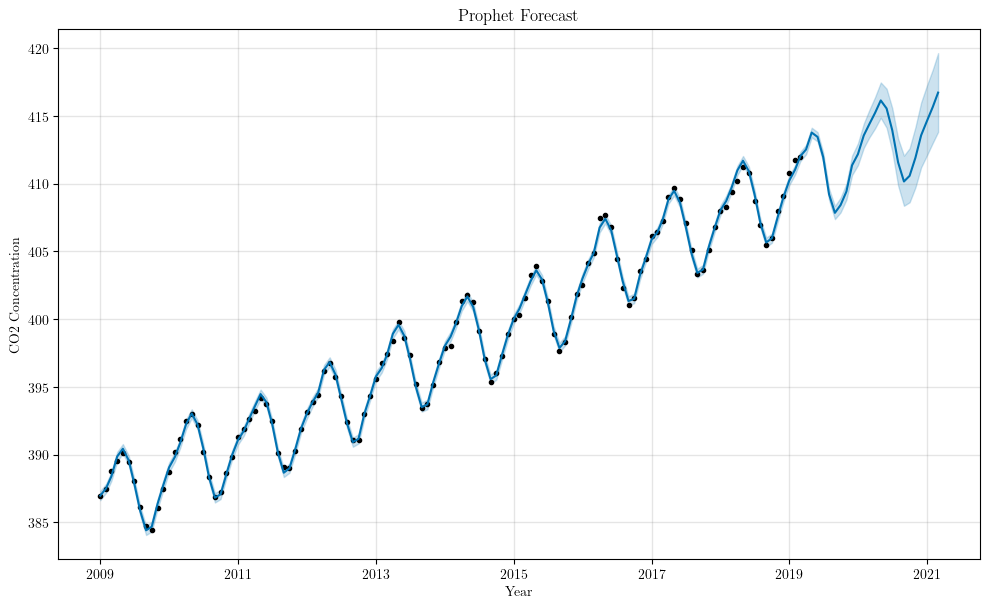

Prophet Mean Absolute Error (MAE): 0.2115
Prophet Root Mean Square Error (RMSE): 0.2690


In [40]:
# Make future predictions
future = prophet_model.make_future_dataframe(periods=24, freq='M')  # 24 months into the future
forecast = prophet_model.predict(future)

# Plot the forecast
prophet_model.plot(forecast)
plt.title('Prophet Forecast')
plt.xlabel('Year')
plt.ylabel('CO2 Concentration')
plt.grid(True)
plt.show()

# Evaluate the Prophet model performance on historical data
actual = prophet_data['y']
predicted = forecast.set_index('ds').loc[prophet_data['ds'], 'yhat']

# Calculate error metrics for Prophet
prophet_mae = mean_absolute_error(actual, predicted)
prophet_rmse = np.sqrt(mean_squared_error(actual, predicted))

print(f"Prophet Mean Absolute Error (MAE): {prophet_mae:.4f}")
print(f"Prophet Root Mean Square Error (RMSE): {prophet_rmse:.4f}")

In [43]:
print(f"SARIMA MAE = {sarima_mae:.4f}")
print(f"SARIMA RMSE = {sarima_rmse:.4f}")

print(f"Auto-model MAE = {auto_model_mae:.4f}")
print(f"Auto-model RMSE = {auto_model_rmse:.4f}")

print(f"Prophet MAE = {prophet_mae:.4f}")
print(f"Prophet RMSE = {prophet_rmse:.4f}")

SARIMA MAE = 0.7657
SARIMA RMSE = 0.8912
Auto-model MAE = 1.0410
Auto-model RMSE = 1.1619
Prophet MAE = 0.2115
Prophet RMSE = 0.2690
